In [ ]:
# calculates correlations between average log expression ratio and 
#  average log impact ratio of the altered genes on all pathways of each metastases pair
# creates SupplFigure 5 with scatter plots (SupplFigure-S5-impact-expression-correl.png)
# and Figure 4 with barplots of the correlations (Figure-4-plot-impact-expression-correl-barplot.png)

In [43]:
library(ggplot2)
library(grid) # for textGrob for common axis titles in grid.arrange
library(gridExtra)
library(pheatmap)
library(scales) # for wrap_format, to wrap labels
library(stringr) # edit names in pheatmap
library(pvclust) # for clustering stability analyses
library(xlsx)

In [51]:
basePath = "/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/publications/2022-my-MelBrainSys-paper/scripts-etc-for-publication/"
setwd(basePath)

In [52]:
# define met. pairs, and annotation colors 
tmp = readRDS(file = "annotation/samplePairs-annotation-colors-clusters.rds")
patient_colors = tmp$patient_colors
tissue_colors = tmp$tissue_colors
neededSamples = tmp$neededSamples
sampleMapping = tmp$sampleMapping
samplePairs = tmp$samplePairs
samplePairPerSubgroup = tmp$samplePairPerSubgroup
subgroupPerSamplePair = tmp$subgroupPerSamplePair
subgroupNames = tmp$subgroupNames
colAnnot = tmp$colAnnot
annotColors = tmp$annotColors

In [53]:
outDirectory = paste0(basePath,"FiguresTables/")

In [54]:
# pathway definitions
pwCategories = readRDS(file = "pathway-categories.rds")
head(pwCategories$signalingPWs$PPAR)

[1] "FABP3"   "CYP4A22" "SCP2"    "CPT2"    "ACADM"   "HMGCS2"

In [55]:
genesPerPathway = unlist(unname(pwCategories),recursive = F)
lapply(head(genesPerPathway,3),head)

$PPAR
[1] "FABP3"   "CYP4A22" "SCP2"    "CPT2"    "ACADM"   "HMGCS2" 

$MAPK
[1] "EPHA2"   "PLA2G2E" "PLA2G2A" "PLA2G5"  "PLA2G2D" "PLA2G2F"

$ErbB
[1] "PIK3CD" "MTOR"   "PIK3R3" "JUN"    "NRAS"   "SHC1"

In [56]:
# pre-calculated impact log-ratios on pathways from each altered gene
metPairImpacts = readRDS(file = "metPairs-impactRatios-onPathways.rds")
head(metPairImpacts,3)
wh = which(!is.na(metPairImpacts$log2_mean_impact_ratio))
length(wh); nrow(metPairImpacts)
metPairImpactsNoNA = metPairImpacts[wh,]

,samplePair,gene,pathway,median_brain_impact,median_nonBrain_impact,log2_median_impact_ratio,log2_mean_impact_ratio
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AIM2,P03_BLun,AIM2,PPAR,5.755740e-08,1.896864e-08,1.601385,1.601385
ZNF677,P03_BLun,ZNF677,PPAR,NA,NA,NA,NaN
CDCA7,P03_BLun,CDCA7,PPAR,1.104414e-07,4.341709e-08,1.346946,1.346946


[1] 40948

[1] 54870

In [57]:
# load log expression values
expr = read.csv(file = "regNet/Data/MelBrainSys-expression.csv", header = T,sep = "\t",stringsAsFactors = F)
head(expr,3)

,geneSymbol,chr,pos,P16_Br,P16_Lu,P17_Ly_YA,P17_Ly_GA,P18_Br,P18_Lu_YA,P18_Lu_GA,⋯,P06_Br_YA,P06_Br_GA,P06_Ly,P64_Lu,P67_Br_BA,P67_Br_GA,P08_Br,P08_St_GA,P08_St_BA,P08_St_YA
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NOC2L,chr1,887127,5.8322955,6.037453,6.303197,6.7279647,6.335936,6.7659108,6.865148,⋯,6.923254,6.642663,6.6936242,6.2764296,6.729276,6.579624,7.265025,7.3369872,7.2165933,7.135830
2,KLHL17,chr1,898531,-0.5621772,1.468977,1.713494,2.3754134,1.321752,3.1430347,2.167239,⋯,2.422577,2.254659,2.6668530,1.0399100,2.383997,3.006990,2.923033,3.5478819,2.7090631,2.852682
3,HES4,chr1,934947,-0.6395067,-4.283633,-1.501055,0.9912391,1.398305,0.1379307,1.940562,⋯,-1.113011,-1.175142,0.0334023,-0.9092056,-2.308214,2.237329,2.026139,0.5083688,-0.6707293,1.881657


In [58]:
impactExprTable = NULL
for (samplePair in names(sampleMapping)) {
    sampleBr = sampleMapping[[samplePair]][[1]]
    sampleExC = sampleMapping[[samplePair]][[2]]
    for (pw in names(genesPerPathway)) {
        wh = which(expr$geneSymbol %in% genesPerPathway[[pw]])
        exprRatio = mean(expr[ wh,sampleBr] - expr[wh,sampleExC])
        impRatio = mean(metPairImpactsNoNA$log2_median_impact_ratio[ 
            metPairImpactsNoNA$pathway == pw & 
            metPairImpactsNoNA$samplePair == samplePair])
        impactExprTable = 
            rbind(impactExprTable,
                  data.frame(stringsAsFactors = F,
                      sample_pair = samplePair, pathway = pw, 
                      "impact_ratio" = impRatio,
                      "expression_ratio" = exprRatio,
                      subgroup = subgroupNames[subgroupPerSamplePair[samplePair]],
                      "subgroup ID" = subgroupPerSamplePair[samplePair]))
    }
}
impactExprTable = impactExprTable[ order(impactExprTable$sample_pair,
                                         impactExprTable$pathway),]

In [59]:
head(impactExprTable,3)

,sample_pair,pathway,impact_ratio,expression_ratio,subgroup,subgroup.ID
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
SG314,P03_BLun,adherens junction,-0.4932753,-0.1312771,slightly lower,SG3
SG334,P03_BLun,Ala Asp Glu metab,-0.3601107,-0.1237003,slightly lower,SG3
SG345,P03_BLun,Antigen processing and presentation,-0.3567411,-0.2727690,slightly lower,SG3


In [24]:
samplePairPerSubgroup

$SG1
[1] "P04_BSki_1" "P08_BSof_2" "P16_BLun"   "P42_BLym_1"

$SG3
[1] "P03_BLun"   "P08_BSof_3" "P18_BLun_1" "P42_BLym_2"

$SG2
[1] "P08_BSof_1" "P18_BLun_2" "P39_BLun"

In [ ]:
corMat = matrix(0,nrow = ncol(medianImpRatiosMx), ncol = 6, 
                dimnames = c(list(colnames(medianImpRatiosMx)), 
                             list(c("spearman_rho","spearman_p","spearman_FDR","pearson_cor","pearson_p","pearson_FDR"))) )
for(sp in colnames(voomExprRatios)) {
    corSp = cor.test(x = medianImpRatiosMx[allGenes,sp], y = voomExprRatios[allGenes,sp],method = "spearman")
    corPe = cor.test(x = medianImpRatiosMx[allGenes,sp], y = voomExprRatios[allGenes,sp],method = "pearson")
    corMat[sp,]=c(corSp$estimate, corSp$p.value, 0, corPe$estimate,corPe$p.value, 0)
}

In [ ]:
corMat[,"spearman_FDR"] = p.adjust(p = corMat[,"spearman_p"], method = "BH")
corMat[,"pearson_FDR"] = p.adjust(p = corMat[,"pearson_p"])

In [71]:
cors = NULL
for(sp in names(sampleMapping)) {
    tmp = cor.test(x = impactExprTable[ impactExprTable$sample_pair==sp,"impact_ratio"], 
            y = impactExprTable[ impactExprTable$sample_pair==sp,"expression_ratio"], method = "pearson")
    cors = rbind(cors, 
                 data.frame(sample_pair = sp, r = round(tmp$estimate,2), p = tmp$p.value))
}
cors$FDR = p.adjust(cors$p)
cors

,sample_pair,r,p,FDR
,<chr>,<dbl>,<dbl>,<dbl>
cor,P03_BLun,0.01,9.150395e-01,1.000000e+00
cor1,P04_BSki_1,-0.57,2.354403e-06,2.589843e-05
cor2,P08_BSof_1,-0.23,7.749613e-02,3.874807e-01
cor3,P08_BSof_2,-0.35,6.061731e-03,4.243212e-02
cor4,P08_BSof_3,-0.48,1.354159e-04,1.354159e-03
cor5,P16_BLun,-0.11,4.098583e-01,1.000000e+00
cor6,P18_BLun_1,-0.01,9.674272e-01,1.000000e+00
cor7,P18_BLun_2,-0.42,9.256182e-04,8.330564e-03
cor8,P39_BLun,-0.37,3.614004e-03,2.891203e-02


In [83]:
corLabels = data.frame(stringsAsFactors = F,sample_pair =  cors$sample_pair,
           label=paste0("r = ",round(cors$r,2),
                        ", p = ",format(cors$p,digits=2),
                        ", FDR = ",format(cors$p,digits=2)
                       ))
corLabels

sample_pair,label
<chr>,<chr>
P03_BLun,"r = 0.01, p = 9.2e-01, FDR = 9.2e-01"
P04_BSki_1,"r = -0.57, p = 2.4e-06, FDR = 2.4e-06"
P08_BSof_1,"r = -0.23, p = 7.7e-02, FDR = 7.7e-02"
P08_BSof_2,"r = -0.35, p = 6.1e-03, FDR = 6.1e-03"
P08_BSof_3,"r = -0.48, p = 1.4e-04, FDR = 1.4e-04"
P16_BLun,"r = -0.11, p = 4.1e-01, FDR = 4.1e-01"
P18_BLun_1,"r = -0.01, p = 9.7e-01, FDR = 9.7e-01"
P18_BLun_2,"r = -0.42, p = 9.3e-04, FDR = 9.3e-04"
P39_BLun,"r = -0.37, p = 3.6e-03, FDR = 3.6e-03"


In [78]:
samplePairPerSubgroup$SG1

[1] "P04_BSki_1" "P08_BSof_2" "P16_BLun"   "P42_BLym_1"

`geom_smooth()` using formula = 'y ~ x'


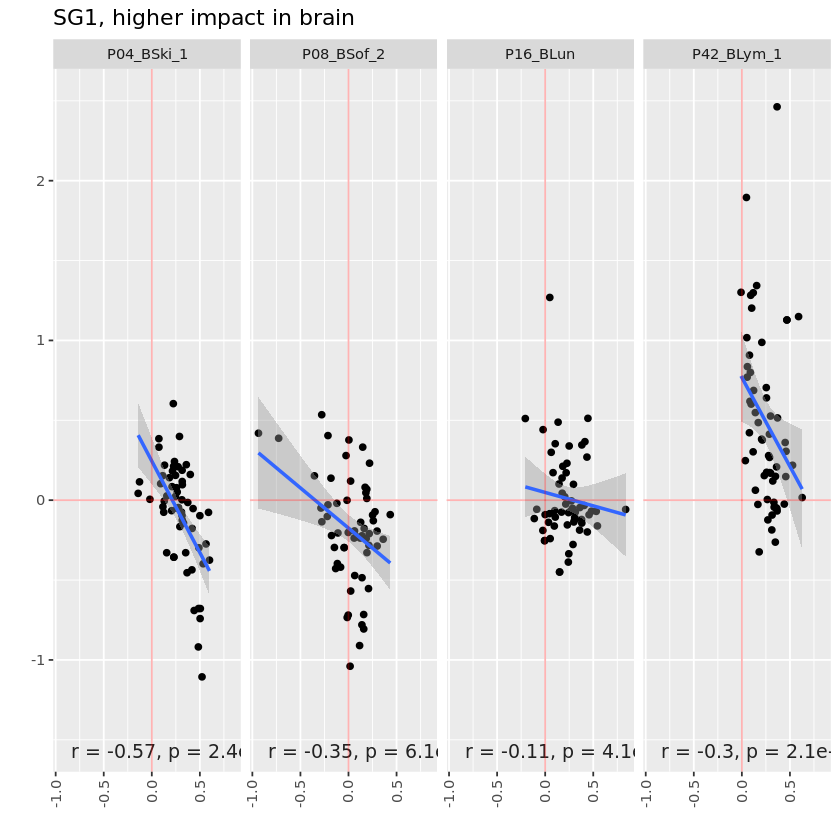

In [84]:
# split by subgroup (higher, balanced, lower impact in brain):
p1 = ggplot(data=impactExprTable[impactExprTable$sample_pair %in% samplePairPerSubgroup$SG1,], 
           mapping = aes(x=impact_ratio,y=expression_ratio)) + geom_point() + 
             facet_wrap(~sample_pair,nrow = 1) + 
             scale_y_continuous(limits=c(-1.5,2.5),labels = wrap_format(10), name = "") + 
             scale_x_continuous(name= "") + ggtitle("SG1, higher impact in brain") + 
            geom_smooth(method=lm, fullrange=F) + # regression line + confidence
             geom_text(data = corLabels[ corLabels$sample_pair %in% samplePairPerSubgroup$SG1,],  
                       mapping = aes(x = -Inf, y = -Inf, label = label), size=4, 
                       hjust   = -0.05,  vjust   = -1, col="#222222") +
            geom_hline(yintercept = 0, col=alpha("red",0.3)) + geom_vline(xintercept = 0, col=alpha("red",0.3)) + 
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1

`geom_smooth()` using formula = 'y ~ x'


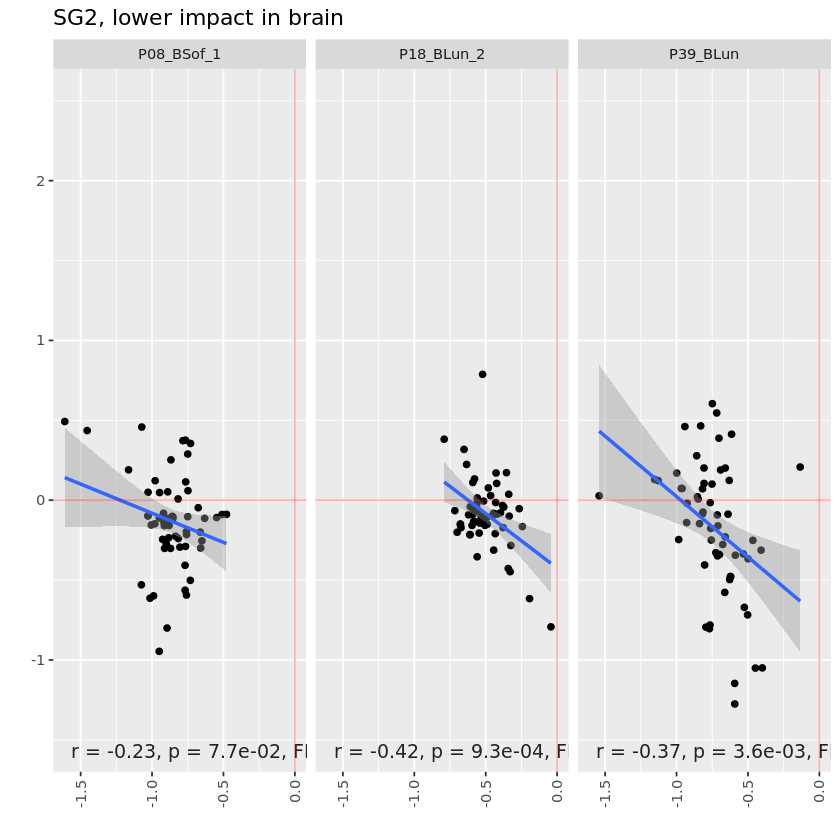

In [85]:
p2 = ggplot(data=impactExprTable[impactExprTable$sample_pair %in% samplePairPerSubgroup$SG2,], 
           mapping = aes(x=impact_ratio,y=expression_ratio)) + geom_point() + 
             facet_wrap(~sample_pair,nrow = 1) + 
             scale_y_continuous(limits=c(-1.5,2.5),labels = wrap_format(10), name = "") + 
             scale_x_continuous(name= "") + ggtitle("SG2, lower impact in brain") + 
            geom_smooth(method=lm, fullrange=F) + # regression line + confidence
            geom_text(data = corLabels[ corLabels$sample_pair %in% samplePairPerSubgroup$SG2,],  
                  mapping = aes(x = -Inf, y = -Inf, label = label), size=4, 
                   hjust   = -0.05,  vjust   = -1, col="#222222") +
            geom_hline(yintercept = 0, col=alpha("red",0.3)) + geom_vline(xintercept = 0, col=alpha("red",0.3)) + 
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p2

`geom_smooth()` using formula = 'y ~ x'


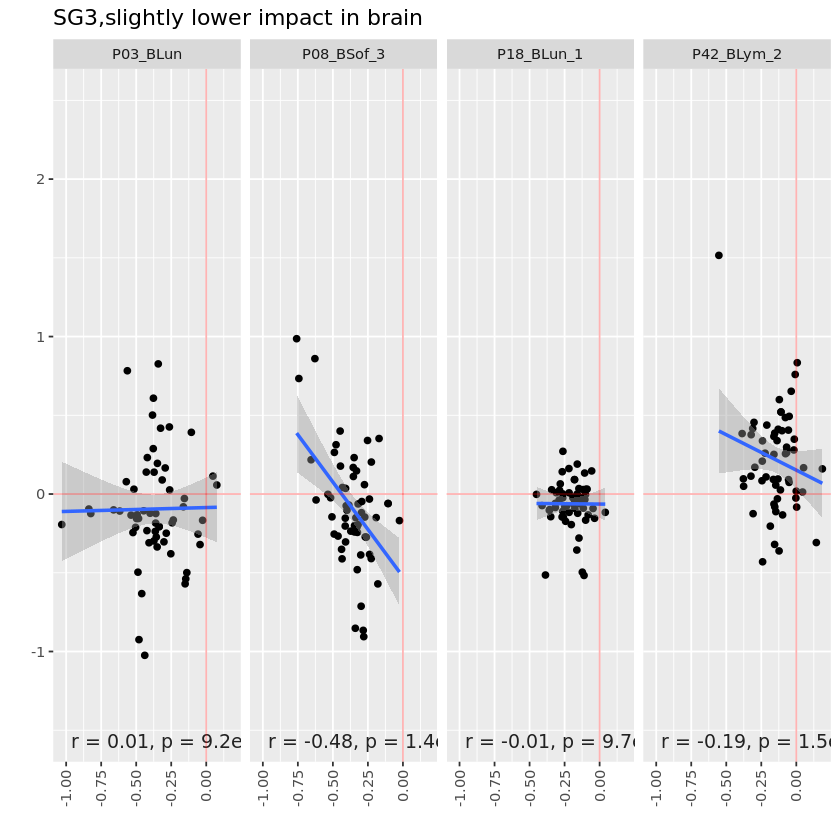

In [86]:
p3 = ggplot(data=impactExprTable[impactExprTable$sample_pair %in% samplePairPerSubgroup$SG3,], 
           mapping = aes(x=impact_ratio,y=expression_ratio)) + geom_point() + 
             facet_wrap(~sample_pair,nrow = 1) + 
             scale_y_continuous(limits=c(-1.5,2.5),labels = wrap_format(10), name = "") + 
             scale_x_continuous(name= "") + ggtitle("SG3,slightly lower impact in brain") + 
            geom_smooth(method=lm, fullrange=F) + # regression line + confidence
            geom_text(data = corLabels[ corLabels$sample_pair %in% samplePairPerSubgroup$SG3,],    
                       mapping = aes(x = -Inf, y = -Inf, label = label), size=4, 
                       hjust   = -0.05,  vjust   = -1, col="#222222") +
            geom_hline(yintercept = 0, col=alpha("red",0.3)) + geom_vline(xintercept = 0, col=alpha("red",0.3)) + 
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p3

In [87]:
png(filename = paste0(outDirectory,"SupplFigure-S5-impact-expression-correl.png"), 
    width = 3000, height = 3000, res=220)
grid.arrange(grobs=list(p1,p3,p2), nrow=3, # widths=c(1,1,1.1), 
            left = textGrob(expression(expression~log[2]~ratio), rot = 90, vjust = 1),
                         bottom = textGrob(expression(impact~log[2]~ratio), vjust = 0.4))
dev.off()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

## Figure 3 - condensed view of correlations

In [115]:
#impExprVoomCorrelSamplePair
correls = data.frame(stringsAsFactors = F,
                     correlation = cors$r, p = cors$p, p_adjusted = cors$FDR, 
                sample_pair = cors$sample_pair)
correls$subgroupID = subgroupPerSamplePair[ correls$sample_pair]
correls$subgroup = as.factor(subgroupNames[ correls$subgroupID])
correls$subgroupNum = as.numeric(gsub("SG","",correls$subgroupID))
head(correls,3)

,correlation,p,p_adjusted,sample_pair,subgroupID,subgroup,subgroupNum
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
1,0.01,9.150395e-01,1.000000e+00,P03_BLun,SG3,slightly lower,3
2,-0.57,2.354403e-06,2.589843e-05,P04_BSki_1,SG1,higher,1
3,-0.23,7.749613e-02,3.874807e-01,P08_BSof_1,SG2,lower,2


In [116]:
t(correls[,c(1,4)])

correlation,0.01,-0.57,-0.23,-0.35,-0.48,-0.11,-0.01,-0.42,-0.37,-0.30,-0.19
sample_pair,P03_BLun,P04_BSki_1,P08_BSof_1,P08_BSof_2,P08_BSof_3,P16_BLun,P18_BLun_1,P18_BLun_2,P39_BLun,P42_BLym_1,P42_BLym_2


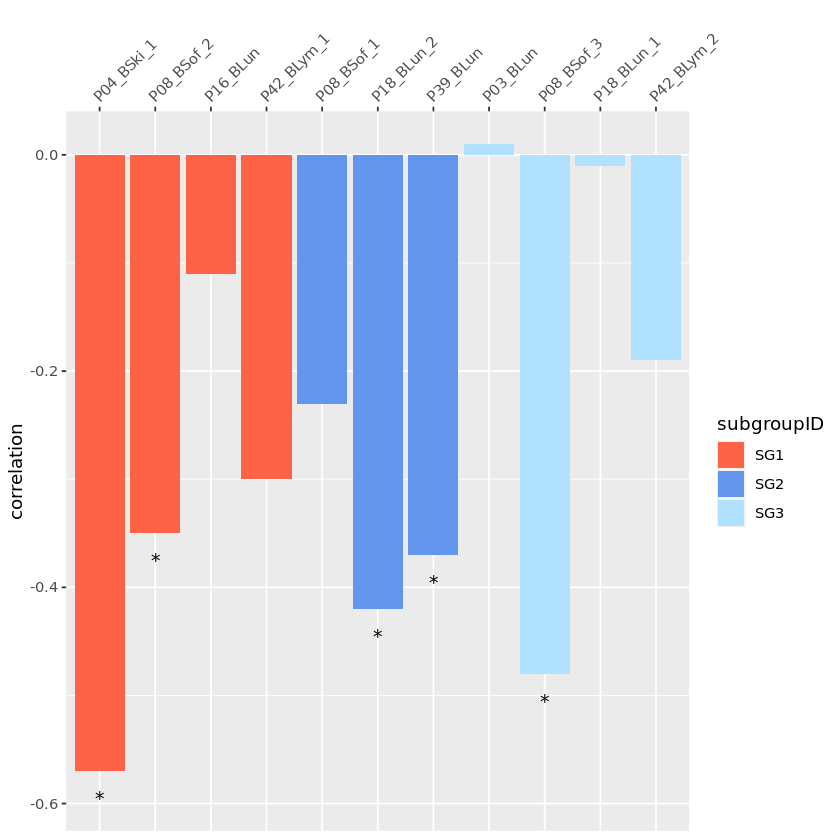

In [114]:
# signif star labels:
o = order(correls$subgroupNum)
whSign = which(correls$p_adjusted[o] < 0.05)
whY = correls$correlation[o][whSign]-0.025

p = ggplot(data = correls,mapping = aes(x=reorder(sample_pair,subgroupNum),
                                        y=correlation, fill=subgroupID)) + 
    geom_bar(stat="identity") + 
    xlab("") + theme(axis.text.x=element_text(angle = 45, hjust = 0)) + 
    scale_x_discrete(position = "top")  + 
    scale_fill_manual(values=c(annotColors$subgroup["SG1"], annotColors$subgroup["SG2"], 
                               annotColors$subgroup["SG3"]), 
                     breaks=c("SG1","SG2","SG3")) + 
    #theme(legend.title = element_blank()) + 
    annotate('text', x = whSign, y =whY, label = '*', size = 4)
p

In [118]:
png(filename = paste0(outDirectory,"Figure-4-plot-impact-expression-correl-barplot.png"),
    width = 1400, height = 1600,res = 240)
p
dev.off()

png 
  2